In [ ]:
%pip install gymnasium

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
from IPython.display import display, clear_output

# Environment

## Discrete observation-action space

In [2]:
class DiscreteUnicycleEnv(gym.Env):
    def __init__(self):
        super(DiscreteUnicycleEnv, self).__init__()

        # Boundaries for the robot
        self.max_x = 20
        self.max_y = 20

        # The action space is [linear_velocity (-1, 0, +1), angular_velocity (-1, 0, +1)]
        self.action_space = spaces.MultiDiscrete([3, 3], start=[-1, -1])

        # The observation space is {'state': [x (0-99), y (0-99), theta (0-7)], 'relative_state': [ex, ey, etheta]} (position of goal relative to the robot)
        self.observation_space = spaces.Dict({
            'state': spaces.MultiDiscrete([self.max_x, self.max_y, 8]),
            'relative_state': spaces.MultiDiscrete([4*self.max_x+1, 4*self.max_y+1, 8], start=[-2*self.max_x, -2*self.max_y,0])
        })

        # Parameters
        self.initial_state = np.array([4, 4, 0], dtype=np.int8)
        self.goal = np.array([16, 16, 2], dtype=np.int8)  # goal position and angle
        
        self.state = self.initial_state.copy()
        self.relative_state = self.get_relative_state()

        # Rendering setup
        self.path = []
        self.fig, self.ax = plt.subplots()

    def reset(self, exploring=False):
        """
        Resets the environment to an initial state and returns the initial observation.
        """
        if exploring:
            self.state = np.random.randint([self.max_x, self.max_y, 8], dtype=np.uint8)
        else:
            self.state = self.initial_state.copy()

        self.relative_state = self.get_relative_state()
        self.path = [self.state[:2].copy()]  # Initialize path with the start position

        return self.get_obs()

    def step(self, action):
        """
        Executes one time step within the environment.
        """
        linear_velocity, angular_velocity = action
        x, y, theta = self.state

        # Update state
        theta = (theta + angular_velocity) % 8
        if theta==0:
            x += linear_velocity
        elif theta==1:
            x += linear_velocity
            y += linear_velocity
        elif theta==2:
            y += linear_velocity
        elif theta==3:
            x -= linear_velocity
            y += linear_velocity
        elif theta==4:
            x -= linear_velocity
        elif theta==5:
            x -= linear_velocity
            y -= linear_velocity
        elif theta==6:
            y -= linear_velocity
        elif theta==7:
            x += linear_velocity
            y -= linear_velocity
        
        # Clip x and y to stay within the bounds
        x = np.clip(x, 0, self.max_x-1)
        y = np.clip(y, 0, self.max_y-1)

        self.state = np.array([x, y, theta], dtype=np.int8)
        self.relative_state = self.get_relative_state()

        # Save the current position to the path
        self.path.append(self.state[:2].copy())

        done = self.is_done()
        reward = self.get_reward()

        return self.get_obs(), reward, done, {}

    def get_relative_state(self):
        """
        Transforms the goal position to be relative to the robot's current position and orientation.
        """
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal

        # Calculate relative position
        dx = goal_x - x
        dy = goal_y - y

        # Rotate to the robot's frame of reference
        if theta % 2 == 0:
            ex = (np.cos(theta*np.pi/4) * dx + np.sin(theta*np.pi/4) * dy) * 2 #*2 is because there can be 200 possible ex states! Same for ey. Look at observation space above
            ey = (-np.sin(theta*np.pi/4) * dx + np.cos(theta*np.pi/4) * dy) * 2
        else:
            ex = (np.cos(theta*np.pi/4) * dx + np.sin(theta*np.pi/4) * dy) / np.sqrt(2) * 2
            ey = (-np.sin(theta*np.pi/4) * dx + np.cos(theta*np.pi/4) * dy) / np.sqrt(2) * 2
        
        ex = np.rint(ex)
        ey = np.rint(ey)
        etheta = (goal_theta - theta) % 8

        return np.array([ex, ey, etheta], dtype=np.int16)

    def get_obs(self):
        return {'state': self.state, 'relative_state': self.relative_state}

    def render(self, mode='human'):
        """
        Renders the environment using Matplotlib.
        """
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        self.ax.clear()

        # Set the plot boundaries with extra space around the robot's operating area
        buffer = 2
        self.ax.set_xlim(- buffer, self.max_x + buffer)
        self.ax.set_ylim(- buffer, self.max_y + buffer)

        # Plot the bounds of the space with solid lines
        self.ax.add_patch(Rectangle((0,0), self.max_x, self.max_y, fill=None, edgecolor='k', linestyle='-', linewidth=2))

        # Plot the goal
        self.ax.plot(goal_x, goal_y, 'ro', label='Goal')
        self.ax.add_patch(Arrow(goal_x, goal_y,  np.cos(goal_theta*np.pi/4), np.sin(goal_theta*np.pi/4),
                                width=0.4, color='r'))

        # Plot the start position
        self.ax.plot(self.path[0][0], self.path[0][1], 'go', label='Start')

        # Plot the robot's path
        path = np.array(self.path)
        self.ax.plot(path[:, 0], path[:, 1], 'k--', label='Path')

        # Plot the robot as a solid rectangle
        width, height = self.max_x/20, self.max_x/30
        robot = Rectangle(
            (x - 0.5 * width, y - 0.5 * height), width, height, angle=np.degrees(theta*np.pi/4), rotation_point='center',
            edgecolor='b', facecolor='b'
        )
        self.ax.add_patch(robot)
        self.ax.add_patch(Arrow(x, y,  np.cos(theta*np.pi/4), np.sin(theta*np.pi/4),
                                width=0.4, color='b'))

        # Plot settings
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.legend()
        self.ax.grid(True)

        # Update the plot
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)

    def close(self):
        plt.close(self.fig)

    def get_reward(self):
        # return: float (reward)
        x, y, theta = self.state
        ex, ey, etheta = self.relative_state

        # Implement code here
        reward = 10

        return reward

    def is_done(self):
        # return: float (reward)
        x, y, theta = self.state
        ex, ey, etheta = self.relative_state

        # Implement code here
        done = False

        return done
    

# Run with graphics

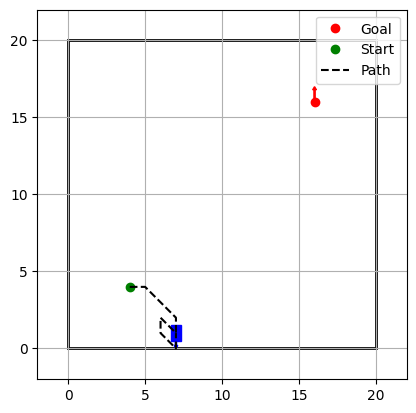

In [4]:
env = DiscreteUnicycleEnv()
obs = env.reset(exploring=False)
done = False

for _ in range(10):
    action = env.action_space.sample()  # Random action
    obs, reward, done, info = env.step(action)
    env.render()
env.close()

In [5]:
print(env.action_space)
print(env.observation_space)

MultiDiscrete([3 3], start=[-1 -1])
Dict('relative_state': MultiDiscrete([81 81  8], start=[-40 -40   0]), 'state': MultiDiscrete([20 20  8]))


# Headless Render (for training)

In [6]:
env = DiscreteUnicycleEnv()
obs = env.reset(exploring=False)
done = False

for _ in range(20):
    action = env.action_space.sample()  # Random action
    obs, reward, done, info = env.step(action)
    print(obs)
env.close()

{'state': array([5, 5, 1], dtype=int8), 'relative_state': array([22,  0,  1], dtype=int16)}
{'state': array([5, 5, 1], dtype=int8), 'relative_state': array([22,  0,  1], dtype=int16)}
{'state': array([5, 5, 1], dtype=int8), 'relative_state': array([22,  0,  1], dtype=int16)}
{'state': array([5, 5, 1], dtype=int8), 'relative_state': array([22,  0,  1], dtype=int16)}
{'state': array([6, 5, 0], dtype=int8), 'relative_state': array([20, 22,  2], dtype=int16)}
{'state': array([7, 6, 1], dtype=int8), 'relative_state': array([19,  1,  1], dtype=int16)}
{'state': array([7, 6, 0], dtype=int8), 'relative_state': array([18, 20,  2], dtype=int16)}
{'state': array([8, 5, 7], dtype=int8), 'relative_state': array([-3, 19,  3], dtype=int16)}
{'state': array([9, 4, 7], dtype=int8), 'relative_state': array([-5, 19,  3], dtype=int16)}
{'state': array([8, 4, 0], dtype=int8), 'relative_state': array([16, 24,  2], dtype=int16)}
{'state': array([8, 4, 7], dtype=int8), 'relative_state': array([-4, 20,  3], dt